# Solving for the Efficient Frontier in Stock Portfolios

<a href="TODO" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

![Banner]()

The Efficient Frontier, a core concept in Harry Markowitz's Modern Portfolio Theory (MPT), is used in quantitative finance to build optimal portfolios that offer the highest expected return for a given level of risk and/or the lowest risk for a given level of return. 

It is constructed by diversifying assets to find the best risk-return trade-off. Which in this article, through python and free financial data we will find the optimal portfolio weights, that maximize expected return while minimizing portfolio variance. The result universe of assets should lie on the efficient frontier.

## Prepare your Environment

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import calculate_profit, load_ticker_prices_ts_df, plot_strategy, load_ticker_ts_df

Running Local...


# Investment Preferences using Indifference Curves and Opportunity Sets

Indifference curves allow investors seeking optimal satisfaction or utility from their portfolio decisions. We use opportunity sets, often visualized through budget lines, to outline viable combinations of assets within specified budget constraints. Promise this section will be fast, let's do a simulation - assume an investor receives $100K a year, they have the choice to:

1. Lend it out at 5% interest rate.
2. Consume it all.
3. Consume more by borrowing at 7% interest rate.

Plotting the opportunity set's budget line, you'd notice it has a negative slope. That's because every dollar consumed, is a dollar that cannot be invested. We add a mock set of indifference curves (aka. a polynomial utility functions), which will be used in making the frontier.'Indefferent' because we assume the consumer will be equally happy on any point on the curve:
$$ f(x) = ax^2 + bx + c $$
- `a^2` is the quadratic term
- `bx` is the linear term
- `c` is a constant

Looking at indifference `Curve 1`, note how to the left of point B in `C1 Delta`, the consumer has to give up less to get more in year 2, but to the right, in `C2 Delta` it's the opposite. `C2 Delta` is not a situation favorable to the consumer.

To find the optimal solution, we have to go up indifference curves, to find ones that intercept or are at a tangent to the budget line. Anything above cannot be used, because there is no investment opportunity. In our example, `Curve 2` is the last one to have opportunity. Here the consumer can maximize their consumption to $120K, with 20k at 7% loan interest rate, and still get opportunity to consume 82K in year 2, paying back the interest on the loan in year 1.

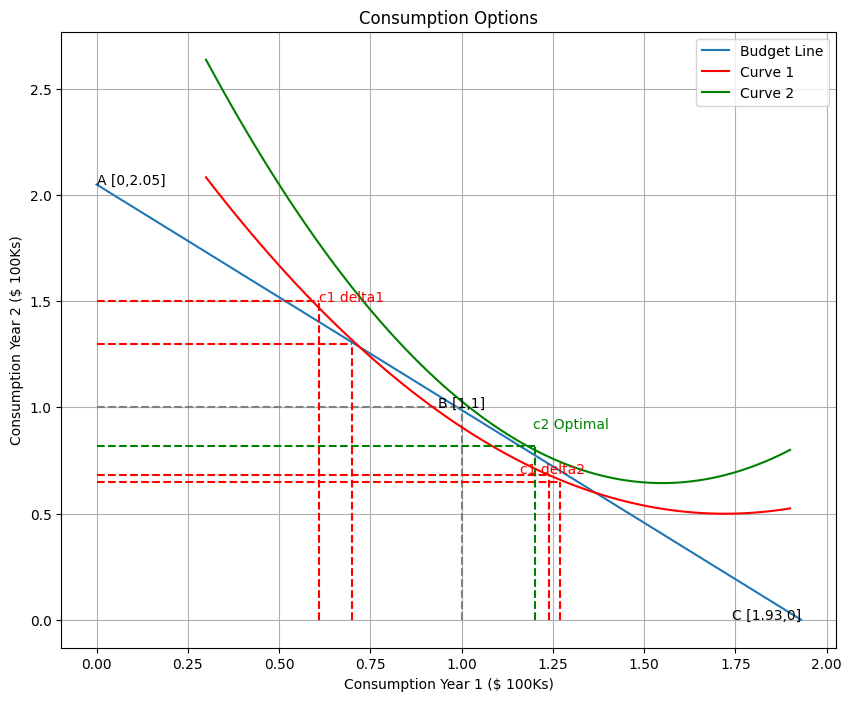

In [2]:
cash_yearly = 1
interest_rate_lending = 0.05
interest_rate_borrowing = 0.07

point_1 = (0, cash_yearly + (cash_yearly * (1 + interest_rate_lending))) 
point_2 = (cash_yearly, cash_yearly) 
point_3 = (cash_yearly + (cash_yearly * (1 - interest_rate_borrowing)), 0)

plt.figure(figsize=(10,8))
plt.plot(*zip(point_1, point_3), label='Budget Line')

plt.annotate(f'A [{point_1[0]},{point_1[1]}]', point_1, ha='left')

plt.annotate(f'B [{point_2[0]},{point_2[1]}]', point_2, ha='center')
plt.plot([cash_yearly, cash_yearly], [0, cash_yearly], linestyle='--', color='gray')
plt.plot([0, cash_yearly], [cash_yearly, cash_yearly], linestyle='--', color='gray')

plt.annotate(f'C [{point_3[0]},{point_3[1]}]', point_3, ha='right')

def utility_curve(x, a, b, c):
    return a * x**2 + b * x + c

# Given points
start_point = (0.3, 2.2)
intercept_point_1 = (0.5, 1.5)
intercept_point_2 = (1.25, 0.75)
end_point = (1.9, 0.5)

coefficients_1 = np.polyfit([start_point[0], intercept_point_1[0], intercept_point_2[0], end_point[0]],
                          [start_point[1], intercept_point_1[1], intercept_point_2[1], end_point[1]], 2)

x_values = np.linspace(start_point[0], end_point[0], 100)
y_values = utility_curve(x_values, *coefficients_1)
plt.plot(x_values, y_values, label='Curve 1', color='red')
plt.plot([0.7, 0.7], [0, 1.3], linestyle='--', color='red')
plt.plot([0, 0.7], [1.3, 1.3], linestyle='--', color='red')
plt.plot([0.61, 0.61], [0, 1.5], linestyle='--', color='red')
plt.plot([0, 0.61], [1.5, 1.5], linestyle='--', color='red')
plt.annotate(f'c1 delta1', [0.7, 1.5], ha='center', color='red')
plt.plot([1.24, 1.24], [0, 0.68], linestyle='--', color='red')
plt.plot([0, 1.24], [0.68, 0.68], linestyle='--', color='red')
plt.plot([1.27, 1.27], [0, 0.65], linestyle='--', color='red')
plt.plot([0, 1.27], [0.65, 0.65], linestyle='--', color='red')
plt.annotate(f'c1 delta2', [1.25, 0.69], ha='center', color='red')


start_point_2 = (0.25, 2.8)
intercept_point_2 = (0.78, 1.4) # budget line is tangent
end_point_2 = (1.9, 0.8)
coefficients_2 = np.polyfit([start_point_2[0], intercept_point_2[0], end_point_2[0]],
                          [start_point_2[1], intercept_point_2[1], end_point_2[1]], 2)
y_values_2 = utility_curve(x_values, *coefficients_2)
plt.plot(x_values, y_values_2, label='Curve 2', color='green')
plt.plot([1.2, 1.2], [0, 0.82], linestyle='--', color='green')
plt.plot([0, 1.2], [0.82, 0.82], linestyle='--', color='green')
plt.annotate(f'c2 Optimal', [1.3, 0.9], ha='center', color='green')

plt.title('Consumption Options')
plt.xlabel('Consumption Year 1 ($ 100Ks)')
plt.ylabel('Consumption Year 2 ($ 100Ks)')

plt.grid(True)
plt.legend()
plt.show()


In [3]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'ORCL', 'CRM', 'ADBE']

START_DATE = '2021-01-04'
END_DATE = '2023-10-31'

tickers_df = load_ticker_prices_ts_df(
    tickers, START_DATE, END_DATE)
tickers_df = tickers_df.dropna(axis=1).pct_change().dropna()  # first % is NaN
tickers_df.head(2)

,AAPL,MSFT,GOOG,AMZN,ORCL,CRM,ADBE
2021-01-05 00:00:00,0.012364,0.000965,0.007337,0.010004,-0.012392,0.005492,0.000721
2021-01-06 00:00:00,-0.033661,-0.025929,-0.003234,-0.024897,-0.002392,-0.024242,-0.039902


Calculate the return vector, which the is the average cummulative returns, annualized:

$$ \text{Annualized Return} = \left( \prod_{i=1}^{n} (1 + R_i) \right)^{\frac{N}{n}} - 1 $$
- `n` represents the number of data points or periods in your time series.
- `Ri` represents the returns for each period. we `+1` to get the absolute returns.
- `N` is the total number of trading days in a year (usually 252 for daily returns).

We annualized to scale up the returns to represent a full year of risk/return:
- Daily return: `0.005` (0.5% return)
- Annualized return: `0.005 * 252 = 1.26` (126% annualized return)

In [4]:
TRADING_DAYS_IN_YEAR = 252

rets = ((1 + tickers_df).prod() ** (TRADING_DAYS_IN_YEAR/len(tickers_df))) - 1
cov_matrix = tickers_df.cov() * TRADING_DAYS_IN_YEAR
rets[:4] * 100.0

AAPL    10.869167
MSFT    17.835695
GOOG    14.243124
AMZN    -6.282798
dtype: float64

In [5]:
cov_matrix.iloc[:4, :4]

,AAPL,MSFT,GOOG,AMZN
AAPL,0.080485,0.058251,0.060955,0.065856
MSFT,0.058251,0.080334,0.066656,0.072414
GOOG,0.060955,0.066656,0.103657,0.082514
AMZN,0.065856,0.072414,0.082514,0.145744


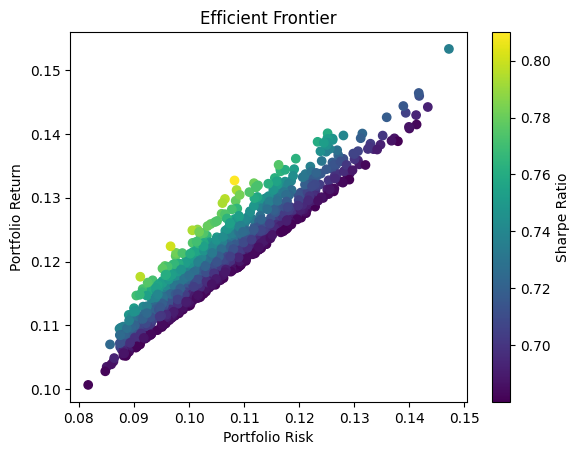

In [26]:
TARGET_RET = 0.2
MIN_SHARPE = 0.68
MAX_RETS = 0.52
MAX_RISK = 0.48
RISK_FREE_RATE = 0.045
MAX_PORTS = 1000

def generate_random_portfolios(num_portfolios, returns, cov_matrix):
    results = []
    weights_record = []

    while(len(results) < num_portfolios):
        weights = np.random.uniform(low=-1, high=1, size=len(tickers))
        weights /= np.sum(np.abs(weights))  # Ensure weights sum to 1

        portfolio_return = np.dot(weights, returns)
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_sharpe = (portfolio_return - RISK_FREE_RATE) / portfolio_std_dev

        if port_sharpe > MIN_SHARPE:
            weights_record.append(weights)
            results.append({'Return': portfolio_return, 'Risk': portfolio_std_dev, 'Sharpe': port_sharpe})

    return results, weights_record

results, weights = generate_random_portfolios(MAX_PORTS, rets, cov_matrix)

# Extract returns, risks, and Sharpe ratios from the filtered results
port_returns = [result['Return'] for result in results]
port_risks = [result['Risk'] for result in results]
port_sharpe_ratios = [result['Sharpe'] for result in results]

# Plot the efficient frontier
plt.scatter(port_risks, port_returns, c=port_sharpe_ratios, cmap='viridis')
plt.title('Efficient Frontier')
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()

Now we define the investable universe using the Merton Matrix Model.
The Merton Model, is used to estimate the probability of default of a company:

- Determine the inverse of the covariance matrix, denoted as `inv_cov_matrix`, which is essential for various risk and return calculations.
- Calculate the risk vector, `min_risk_vect` - to evaluate risk and expected returns.
- Calculate the expected return vector, `expect_ret_vect` - also to evaluate risk and expected returns.

In additon, 3 metrics to evaluate the assets combinations:

1. **Constant Return:** We found that the expected return of the portfolio is given by `rets_constant`. This represents the total expected return of the portfolio when each asset's weight is set to an equal amount.

2. **Linear Return:** The linear expected return, denoted as `rets_linear`, quantifies the portfolio's expected return when assets are weighted proportionally to their individual expected returns.

3. **Quadratic Return:** The quadratic expected return, `rets_quadratic`, represents the expected return of the portfolio when assets are allocated based on their risk levels.

Finally, we assessed the scaling parameter, `scaling_param`, which indicates the trade-off between risk and return in the portfolio. This parameter is a crucial consideration in portfolio optimization and asset allocation.

In [27]:
ones = np.ones(len(rets))  # Equal wieghted portfolio representation
inv_cov_matrix = np.linalg.inv(cov_matrix) # COV represents movements, its inverse minimizes these

# For optimization facets
min_risk_vect = np.matmul(ones, inv_cov_matrix) # Sensitivity to variance
expect_ret_vect = np.matmul(rets, inv_cov_matrix)

# Quadratic relationship between variance and return using a utility function.
rets_constant = np.sum(ones * min_risk_vect)
rets_linear = np.sum(rets * min_risk_vect)
rets_quadratic = np.sum(rets * expect_ret_vect)
utility_func = (rets_quadratic * rets_constant) - (rets_linear ** 2)

# Minimum variance
mvp = min_risk_vect / rets_constant
mvp_ret = rets_linear / rets_constant
mvp_risk = np.sqrt(1 / rets_constant)

# Tangecy (0 risk free)
tan = expect_ret_vect / rets_linear
tan_ret = rets_quadratic / rets_linear
tan_risk = np.sqrt(rets_quadratic) / rets_linear

# merton matrix model assumes no restrictions on short.
tickers[:4], mvp[:4], tan[:4]

(['AAPL', 'MSFT', 'GOOG', 'AMZN'],
 array([ 0.30897555,  0.26333097,  0.10969367, -0.03573329]),
 array([ 0.10338633,  1.46589092,  0.55501645, -0.87466763]))

In [28]:
TEN_BASIS_POINTS = 0.001
exp_rets = np.arange(0, MAX_RETS, TEN_BASIS_POINTS)
risk_std = np.sqrt(((rets_constant * (exp_rets ** 2)) - 
                    (2 * rets_linear * exp_rets) + rets_quadratic) / utility_func)

Now lets build 2 portfolios that will set the boundaries:
1. Minimum variance portfolio - he MVP the tip of the frontier.
2. Tangency portfolio - Market portfolio in CAPM and is the hpoint of tageny and the secutiries markett line.

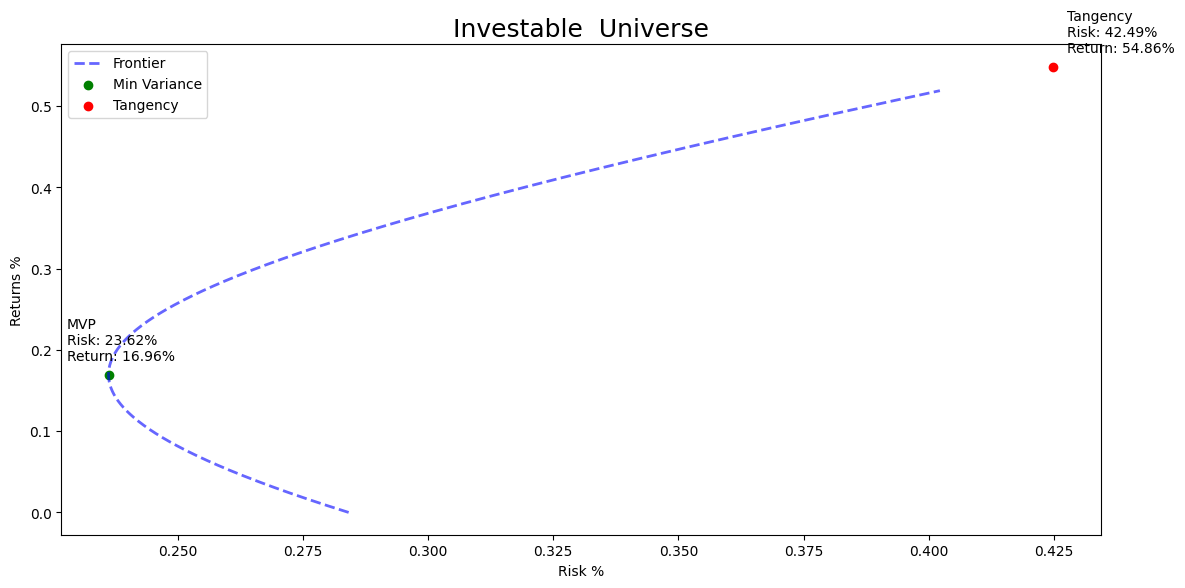

In [29]:
plt.figure(figsize=(12, 6))
plt.title(f'Investable  Universe', fontsize=18)

plt.plot(risk_std, exp_rets, linestyle='--', color='blue', label="Frontier", linewidth=2, alpha=0.6)
plt.scatter(mvp_risk, mvp_ret, color='green', label="Min Variance")
plt.annotate(f'MVP\nRisk: {mvp_risk*100:.2f}%\nReturn: {mvp_ret*100:.2f}%', (mvp_risk, mvp_ret), textcoords="offset points", xytext=(-30,10))

plt.scatter(tan_risk, tan_ret, color='red', label="Tangency")
plt.annotate(f'Tangency\nRisk: {tan_risk*100:.2f}%\nReturn: {tan_ret*100:.2f}%', (tan_risk, tan_ret), textcoords="offset points", xytext=(10,10))

plt.legend(loc='upper left', fontsize=10)
plt.xlabel('Risk %')
plt.ylabel('Returns %')
plt.tight_layout()
plt.show()

Solving returns

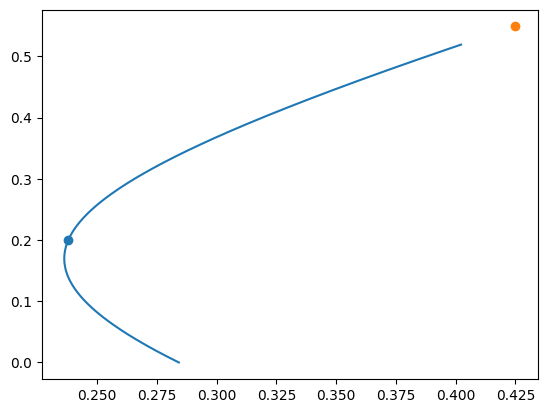

In [30]:
opt_port = None
opt_risk = None
opt_ret = None
# if target_ret < mvp_ret -> opt_x = mvp_x

# MVP Weigh
mvp_weights = (rets_quadratic - (rets_linear * TARGET_RET))/utility_func
# TAN Weigh
tan_weights = ((rets_constant * TARGET_RET) - rets_linear)/utility_func

opt_port = (mvp_weights*min_risk_vect) + (tan_weights*expect_ret_vect)
opt_ret = np.sum(opt_port*rets)
opt_risk = np.sqrt(((rets_constant * (opt_ret ** 2)) - 
                (2 * rets_linear * opt_ret) + rets_quadratic) / utility_func)

plt.plot(risk_std, exp_rets)
plt.scatter(opt_risk, opt_ret)
plt.scatter(tan_risk, tan_ret)

# Conclusion

TODO

![footer]()

## References

- https://www.investopedia.com/terms/m/mertonmodel.asp
- https://mathworld.wolfram.com/MatrixInverse.html


## Github

Article here is also available on [Github](https://github.com/adamd1985/quant_research/blob/main/oscilators-quant.ipynb)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/trading-oscillators-quant)


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.